In [1]:
import numpy as np
import pandas as pd
import os
import multiprocessing as mul
from multiprocessing import Process
import matplotlib.pyplot as plt
#import seaborn as sns
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from IPython.display import clear_output
from scipy.stats import chi2
from scipy.stats import norm
from scipy.stats import gaussian_kde
import scipy.stats as sct
from astropy.coordinates import SkyCoord as scr
from astropy import units as u

In [2]:
####
#### IMPORTING AND SPLITTING ICDATA $$$


path = "/media/darkwake/VIB2/Project-IceCube/icecube_10year_ps/events"
filenames = ["IC40_exp.csv", "IC59_exp.csv","IC79_exp.csv", "IC86_I_exp.csv", "IC86_II_exp.csv",
"IC86_III_exp.csv", "IC86_IV_exp.csv", "IC86_V_exp.csv", "IC86_VI_exp.csv", "IC86_VII_exp.csv"]
file = filenames[0]
f = open(os.path.join(path, file), 'r')
lines = f.readlines()
column=lines[0].split()
column.pop(0)
content = []
for file in filenames:
    f = open(os.path.join(path, file), 'r')
    lines = f.readlines()
    for line in lines[1:]:
        content.append(line.split())
    f.close()
icdata = pd.DataFrame(content, columns=column)
icdata['log10(E/GeV)'] = [float(i) for i in icdata['log10(E/GeV)']]


In [3]:


#IMPORTING MSPDATA
f = open("/media/darkwake/VIB2/Project-IceCube/allpsr.txt", 'r')
lines = f.readlines()

content=[]
column=lines.pop(0).split()
for line in lines[:]:
    content.append(line.split())
    #the INITAL DATABASE IS CLUTTERED SO WE REMOVE THE NULL COLUMNS AND OTHER CLUTTER
mspdata = pd.DataFrame(content).dropna().drop_duplicates()#.drop(range(0,6)).dropna().drop([2,6,8,10,11,13,14], axis=1)
f.close()
line = []
lines = []

mspdata.columns = column
column = []
content=[]
mspdata = mspdata.sort_values('DECJD')
mspdata.dropna(inplace=True)
mspdata = mspdata.reset_index()
mspdata = mspdata.drop(["index", "#"], axis=1)

In [4]:
icdata

,MJD[days],log10(E/GeV),AngErr[deg],RA[deg],Dec[deg],Azimuth[deg],Zenith[deg]
0,54562.37911273,3.31,0.48,203.024,16.760,218.374,106.712
1,54562.38662244,5.17,0.62,75.024,-13.371,349.100,76.646
2,54562.38789162,3.92,0.56,97.501,11.290,327.060,101.291
3,54562.39267689,5.57,1.13,305.857,-33.932,120.413,56.090
4,54562.40477593,5.80,1.11,143.516,-38.279,287.171,51.684
...,...,...,...,...,...,...,...
1134445,58307.96110988,5.14,0.20,221.246,-59.959,141.239,29.956
1134446,58307.96266638,2.94,1.23,191.547,4.415,171.627,94.312
1134447,58307.96355617,2.88,0.30,308.127,42.543,55.437,132.606
1134448,58307.96397167,2.98,0.21,332.199,44.720,31.489,134.811


In [5]:
mspdata

,NAME,Gl,Gb,RAJD,DECJD,P0,F0,DIST
0,J1852-0000,33.066,-0.277,283.16736,-0.00708,1.92066632921,0.520652642675,5.776
1,J1843-0000,32.013,1.768,280.86652,-0.01153,0.880334321703,1.13593208324,3.336
2,J1849-0001,32.638,0.527,282.2568,-0.02151,0.038522586319205,25.958797047369,*
3,J1852-0002g,32.985,-0.177,283.04,-0.03,0.2451,4.079967,5.591
4,J1850-0002g,32.738,0.305,282.5,-0.03,0.89336,1.11937,5.732
...,...,...,...,...,...,...,...,...
3238,J0152+0948,146.812,-50.221,28.0989,9.8028,2.74664729014,0.364080238329,2.477
3239,J1908+0949g,43.562,0.797,287.03,9.82,0.00905,110.497238,6.001
3240,J0550+09,197.055,-8.774,87.6,9.85,1.745,0.573066,1.804
3241,B1914+09,44.556,-1.019,289.134769,9.857216,0.2702544395645,3.700216735057,1.904


In [6]:
msra = [float(i) for i in mspdata['RAJD']]
msdec = [float(i) for i in mspdata['DECJD']]
icra = [float(i) for i in icdata['RA[deg]']]
icdec = [float(i) for i in icdata['Dec[deg]']]
icang = [float(i) for i in icdata['AngErr[deg]']]
global p, lg
p = len(msra)
lg = len(icra) // p + 1
#cut = 20
#cone = 3
#psrno = 0

In [12]:
def hvovec(lon1, lat1, lon2, lat2):

    #Convert decimal degrees to Radians:
    lon1 = np.deg2rad(lon1)
    lat1 = np.deg2rad(lat1)
    lon2 = np.deg2rad(lon2)
    lat2 = np.deg2rad(lat2)

    #Implementing Haversine Formula: 
    dlon = np.subtract(lon2, lon1)
    #dlat = np.subtract(lat2, lat1)

    a = np.add(np.multiply(np.sin(lat1), np.sin(lat2)), np.multiply(np.multiply(np.cos(lat1), np.cos(lat2)), np.cos(dlon)))

    return np.abs(np.rad2deg(np.arccos(a)))




def angfinder(b, cut):
    ang = []
    for a in range(lg):
        
        if a != lg - 1:
        #try:
            ilo = icra[a*p:a*p + p]
            ila = icdec[a*p:a*p + p]
            lo = msra[b] * np.ones(p)
            la = msdec[b] * np.ones(p)
            temp = hvovec(ilo, ila, lo, la)
            for tt in range(len(temp)):
                if temp[tt] > cut:
                    temp[tt] = -1
            ang.extend(temp)
        else:
        #except:
            ilo = icra[a*p:]
            ila = icdec[a*p:]
            ext = len(ilo)
            lo = msra[b] * np.ones(ext)
            la = msdec[b] * np.ones(ext)
            temp = hvovec(ilo, ila, lo, la)
            #ang.extend(hvovec(ilo, ila, lo, la))
            for tt in range(len(temp)):
                if temp[tt] > cut:
                    temp[tt] = -1
            ang.extend(temp)
        
    return ang



def S_ij(i, aang, cut):### $P_i[a] = \dfrac{ns[a]}{N} S[a] + \left(1 - \dfrac{ns[a]}{N}\right)B[a]$ if ns 
        
    arr = []
    for j in range(0,len(icdata)):
        ang = aang[j]
        if ang != -1:
            if ang < cut:
                sg = np.deg2rad(icang[j]) ** 2
                ang = np.deg2rad(ang) ** 2
                arr.append(np.exp(-1 * ang / (2 * sg)) / (2 * np.pi * sg))
    return arr


def nsang(aang, cut):
    count = 0
    for j in aang:
        if j != -1:
            if j < cut:
                count += 1
    return count

'''
def bg(i, cone, ang,Ns):
    icdect = [icdec[i] for i in range(len(ang)) if ang[i] != -1]
    #Calculating total no of neutrino events within delta +/- cone of ith PULSAR (not neutrino)
    count = np.count_nonzero(np.abs(np.subtract(msdec[i],icdect))<cone)
    #calculating solid angle with lt deg conesxipy
    sang = 2 * np.pi * (np.sin(np.deg2rad(msdec[i] + cone)) - np.sin(np.deg2rad(msdec[i] - cone)))
    return count/sang
'''

def bg(psrno, cone, ang):
    tempnudec = []
    for i in range(len(ang)):
        if ang[i] != -1:
            tempnudec.append(np.sin(np.deg2rad(icdec[i])))#APPENDING SIN(Decl) OF ALL NEUTRINOS WITHIN THE SPECIFIED CUT
    
    binwidth = np.sin(np.deg2rad(msdec[psrno] + cone)) - np.sin(np.deg2rad(msdec[psrno] - cone))
    sin_dpsr = np.sin(np.deg2rad(msdec[psrno]))
    bins = np.arange(-1, 1, binwidth)
    ht, walls = np.histogram(tempnudec, bins, density=True)
    bctr = (bins[1:]+bins[:-1])/2
    i=np.argmin(np.abs(bctr-sin_dpsr))
    return ht[i]   

#B = bg(psrno)

def Pr(x, Ns, S, B):
    nsN = x/Ns
    return np.add(np.multiply(nsN , S), np.multiply(np.subtract(1, nsN), B))

def TS(i, x, S, B, Ns):
    return 2*np.sum(np.log(Pr(x,  Ns, S, B)/B))


def TSmax(i, S, B, Ns):
    #returns the TSmax for i^th GRB
    nll = lambda x: -TS(i,x, S, B, Ns)
    soln = minimize(nll, 3 ,bounds=((0,None),))
    ns = float(soln.x)
    return ns

psrno = 258
cut = 20
cone = 3
aang = angfinder(psrno, cut)
Ns = nsang(aang, cut)
S = S_ij(psrno, aang, cut)
B = bg(psrno,cone, aang)

TSmax(258, S, B, Ns)

B

TS(258, TSmax(258, S, B, Ns), S, B, Ns)

xx = range(0, 1001)
tns = [TS(psrno, x, S, B, Ns) for x in range(1001)]
plt.plot(xx, tns)

In [13]:
def singpsr2(psrno = 0):
    cut = 20
    cone = 3
    aang = angfinder(psrno, cut)
    Ns = nsang(aang, cut)
    #Ns = len(icra)
    S = S_ij(psrno, aang, cut)
    B = bg(psrno,cone, aang)#/(2 * np.pi)
    #TS(psrno, 0)
    maxns = TSmax(psrno, S, B, Ns)
    return [maxns, np.sqrt(TS(psrno, maxns, S, B, Ns))]
tsmax = []
errpsr = []
pool = mul.Pool(8, maxtasksperchild=800)
op_async = pool.map_async(singpsr2, range(p))
tsmax = op_async.get()
op_async = []
pool = []
'''
for i in range(p):
    #try:
    tsmax.append(singpsr2(i))
    #except TypeError:
     #   errpsr.append(i)'''
maxns = []
sqrtts = []
for i in tsmax:
    maxns.append(i[0])
    sqrtts.append(i[1])

#### amplitude fixed to total no of events/no of bins between 0 and 1 and then do a fit to this

for i in range(p):
    if sqrtts[i]**2 < 9 * 10 **(-2):
        print([i, sqrtts[i]**2])

In [14]:
np.savetxt('tsmax.txt', sqrtts)

In [15]:
max(sqrtts)

9.379201942016524

psrno = 1834
cut = 20
cone = 3
ang = angfinder(psrno, cut)
s4 = S_ij(psrno, ang, cut)
n4 = nsang(ang, cut)
b4 = bg(psrno, cone, ang)


b4

TSmax(psrno, s4, b4, n4)

TS(psrno, 1000, s4, b4, n4)

In [16]:
binnedsts, wsts = np.histogram(sqrtts, 10)

ne01 = 3
amp  = p/3.0#np.sum(binnedsts)/ne01
#binnedsts = binnedsts/amp
yerr = np.sqrt(binnedsts)
b2 = binnedsts[(binnedsts>0)]
yerr2 = yerr[(binnedsts>0)]
x=0.5*(wsts[1:]+ wsts[:-1])
x2 = x[(binnedsts>0)]
xerr=x[0]-wsts[0]

In [17]:
#gaussian = lambda x, mean, var:  amp*norm.pdf(x, mean, var)
def gaussian(x,mean,sd):
#    mean=0.114
    A=p/3.0
    return A*np.exp(-(x - mean) ** 2.0 / sd ** 2.0)
gparam, gerr = curve_fit(gaussian, x2, b2,  p0=[0.1, 1.0],sigma=yerr2, absolute_sigma=True)#, method='trf')
gx = np.linspace(0, wsts[-1], 100)

kde = lambda x, binnedsts, var: max(b2)*gaussian_kde.pdf()
kparam, kerr = curve_fit(kde, x2, b2,  p0=[0.1, 1.0],sigma=yerr2, absolute_sigma=True, maxfev = 100000, method='dogbox')
kx = np.linspace(0, max(wsts), 100)

In [18]:
gparam

array([-3.1893486 ,  5.71927821])

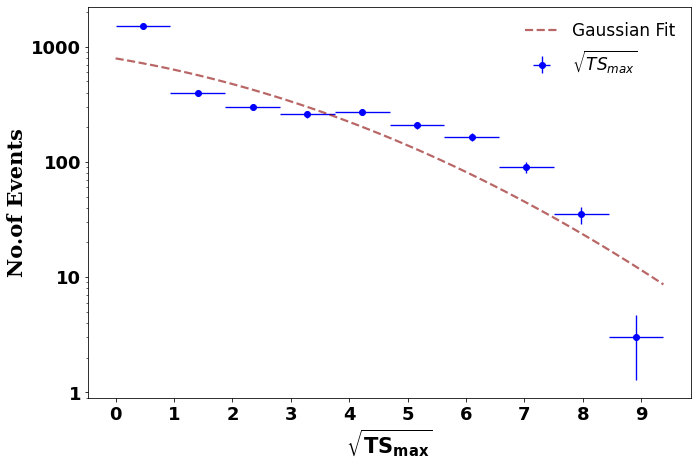

In [19]:
font = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 21,
        }
plt.figure(figsize=(10.8,7.2))
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], fontsize=18, fontweight='bold')
plt.yscale('log')
plt.yticks([1, 10, 100, 1000, 10000], [1, 10, 100, 1000, 10000], fontsize=18, fontweight='bold')

plt.errorbar(x, binnedsts, xerr=xerr,yerr=yerr,  aa = True, barsabove = True, fmt='ob',ecolor='blue', elinewidth=1.35, label='$\sqrt{TS_{max}}$')
plt.plot(gx,gaussian(gx, gparam[0], gparam[1]),'--', alpha=0.6, label=f'Gaussian Fit', color='darkred', lw=2.2)

plt.xlabel("$\mathbf{\sqrt{TS_{max}}}$", fontweight='bold', fontdict=font)
plt.ylabel("No.of Events", fontweight='bold', fontdict=font)
#plt.grid(True, which='major')
legend =plt.legend(prop={'size':17}, framealpha=0)
legend.get_frame().set_facecolor('none')
plt.savefig("outputs/sqrt(TSmax)final.pdf")
plt.show()

In [160]:
#arr = [i  for i in range(len(sqrtts)) if sqrtts[i] < 0.01]
#len(arr)
#psra = [msra[i] for i in arr]
#psdec = [msdec[i] for i in arr]
psra = msra
psdec = msdec
psra2 = np.deg2rad([(i + 180)%360 - 180 for i in psra])
#[psra[0], psra2[0]]
psra = np.deg2rad(psra)
psdec = np.deg2rad(psdec)
p3 =[]
for i in psra2:
    if i < 0 and i > np.deg2rad(-110):
        p3.append(i)

radec = scr(ra = msra * u.degree, dec = msdec * u.degree, frame = 'icrs')           #CONVERSION
radec = radec.galactic      #CONVERSION FROM RA,DEC TO GALACTIC COORDINATES

gl = [(i + np.pi)%(2*np.pi) - np.pi for i in radec.l.radian]
gb = radec.b.radian

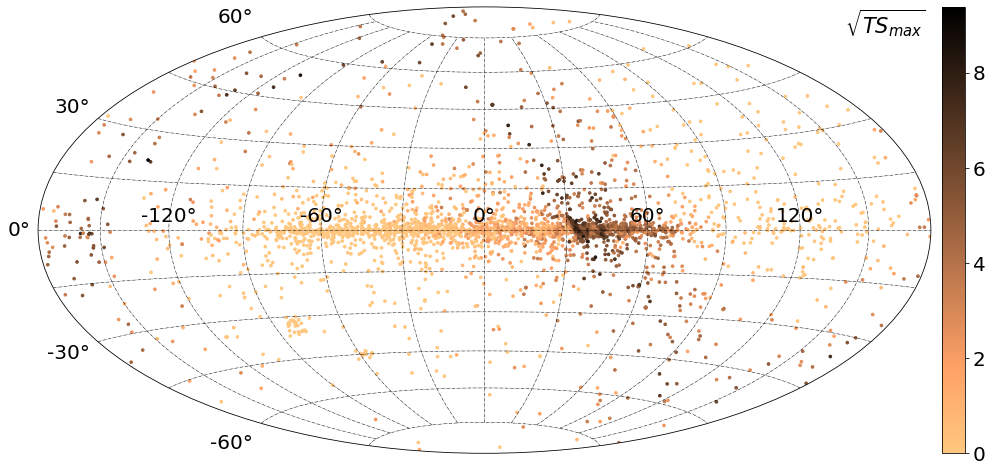

In [165]:
comap = 'copper_r'
fig = plt.figure(figsize=(16, 10))
plt.rcParams.update({'font.size': 20})
ax2 = plt.subplot(projection='hammer')
plott = ax2.scatter(gl, gb,marker='o', c=sqrtts, cmap=comap, s = 7, label='Pulsars')
#ax2.scatter(msra, msdec,marker='o',color='b', s = 1.2)
#ax2.scatter(icra, icdec, marker='.',color='green', alpha=0.05, s = 0.1)
ax2.xaxis.set_major_locator(plt.FixedLocator(np.pi / 3 * np.linspace(-2,2, 5)))
ax2.xaxis.set_minor_locator(plt.FixedLocator(np.pi / 6 * np.linspace(-5, 5, 11)))
ax2.yaxis.set_major_locator(plt.FixedLocator(np.pi / 6 * np.linspace(-2, 2, 5)))
ax2.yaxis.set_minor_locator(plt.FixedLocator(np.pi / 12 * np.linspace(-5, 5, 11)))
ax2.grid(True, which='both', color='black', lw=0.5, ls='-.')
#ax2.axvspan(min(p3), max(p3), color='pink', alpha=0.5)
#ax2.set_title('PULSARS WITH TSmax ~0\nHAMMER projection \n', fontdict=font)

cax = fig.add_axes([ax2.get_position().x1+0.01,ax2.get_position().y0,0.02,ax2.get_position().height])
cbar = fig.colorbar(plott, cax=cax)
cbar.set_label('$\sqrt{TS_{max}}$\n\n', loc='top', rotation=0,labelpad=-60, fontdict=font)
#plt.suptitle(filenamewithpath.replace('icecube_10year_ps/events/','').replace('_exp','') + ' GALACTIC')

plt.savefig('outputs/psr-tsmax_hmp-HP-Galactic.pdf')
plt.show()

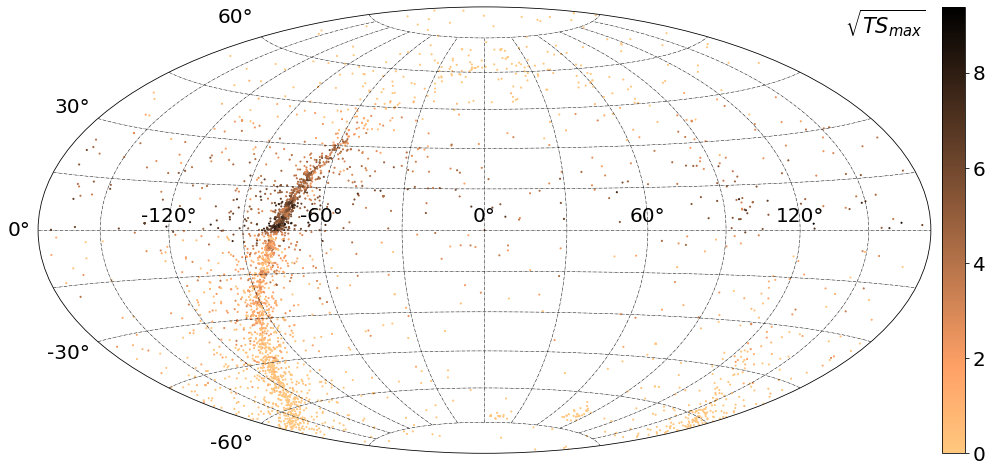

In [157]:
#PLOT RA, DEC
comap = 'copper_r'
fig = plt.figure(figsize=(16, 10))
plt.rcParams.update({'font.size': 20})
ax2 = plt.subplot(projection='hammer')
plott = ax2.scatter(psra2, psdec,marker='o', c=sqrtts, cmap=comap, s = 1.2, label='Pulsars')
#ax2.scatter(msra, msdec,marker='o',color='b', s = 1.2)
#ax2.scatter(icra, icdec, marker='.',color='green', alpha=0.05, s = 0.1)
ax2.xaxis.set_major_locator(plt.FixedLocator(np.pi / 3 * np.linspace(-2,2, 5)))
ax2.xaxis.set_minor_locator(plt.FixedLocator(np.pi / 6 * np.linspace(-5, 5, 11)))
ax2.yaxis.set_major_locator(plt.FixedLocator(np.pi / 6 * np.linspace(-2, 2, 5)))
ax2.yaxis.set_minor_locator(plt.FixedLocator(np.pi / 12 * np.linspace(-5, 5, 11)))
ax2.grid(True, which='both', color='black', lw=0.5, ls='-.')
#ax2.axvspan(min(p3), max(p3), color='pink', alpha=0.5)
#ax2.set_title('PULSARS WITH TSmax ~0\nHAMMER projection \n', fontdict=font)

cax = fig.add_axes([ax2.get_position().x1+0.01,ax2.get_position().y0,0.02,ax2.get_position().height])
cbar = fig.colorbar(plott, cax=cax)
cbar.set_label('$\sqrt{TS_{max}}$\n\n', loc='top', rotation=0,labelpad=-60, fontdict=font)
#plt.suptitle(filenamewithpath.replace('icecube_10year_ps/events/','').replace('_exp','') + ' GALACTIC')

plt.savefig('outputs/psr-tsmax_hmp-HP.pdf')
plt.show()


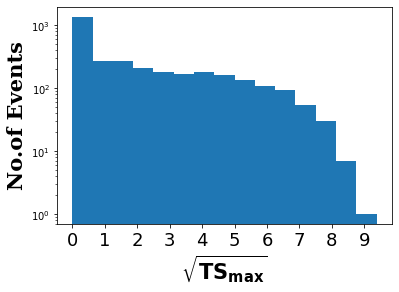

In [82]:
plt.hist(sqrtts, 15)
plt.xlabel("$\mathbf{\sqrt{TS_{max}}}$", fontweight='bold', fontdict=font)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], fontsize=18)
plt.ylabel("No.of Events", fontweight='bold', fontdict=font)
plt.yscale('log')
plt.show()

In [41]:
arr = [i  for i in range(len(sqrtts)) if sqrtts[i] < 0.01]
len(arr)
psra = [msra[i] for i in arr]
psdec = [msdec[i] for i in arr]
psra2 = np.deg2rad([(i + 180)%360 - 180 for i in psra])
#[psra[0], psra2[0]]
psra = np.deg2rad(psra)
psdec = np.deg2rad(psdec)
p3 =[]
for i in psra2:
    if i < 0 and i > np.deg2rad(-110):
        p3.append(i)
max(p3)

-0.025832108622626863

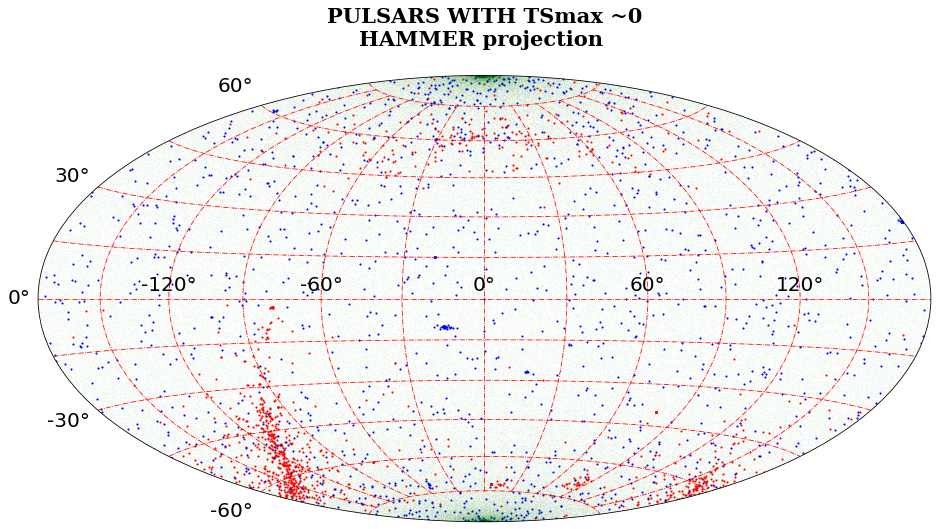

In [45]:
#PLOT RA, DEC
fig = plt.figure(figsize=(16, 10))
plt.rcParams.update({'font.size': 20})
ax2 = plt.subplot(projection='hammer')
ax2.scatter(psra2, psdec,marker='o',color='r', s = 1.2)
ax2.scatter(msra, msdec,marker='o',color='b', s = 1.2)
ax2.scatter(icra, icdec, marker='.',color='green', alpha=0.05, s = 0.1)
ax2.xaxis.set_major_locator(plt.FixedLocator(np.pi / 3 * np.linspace(-2,2, 5)))
ax2.xaxis.set_minor_locator(plt.FixedLocator(np.pi / 6 * np.linspace(-5, 5, 11)))
ax2.yaxis.set_major_locator(plt.FixedLocator(np.pi / 6 * np.linspace(-2, 2, 5)))
ax2.yaxis.set_minor_locator(plt.FixedLocator(np.pi / 12 * np.linspace(-5, 5, 11)))
ax2.grid(True, which='both', color='r', lw=0.8, ls='-.')
#ax2.axvspan(min(p3), max(p3), color='pink', alpha=0.5)
ax2.set_title('PULSARS WITH TSmax ~0\nHAMMER projection \n', fontdict=font)
plt.savefig('outputs/psr-tsmax0-HP.pdf')
#plt.suptitle(filenamewithpath.replace('icecube_10year_ps/events/','').replace('_exp','') + ' GALACTIC')
plt.show()


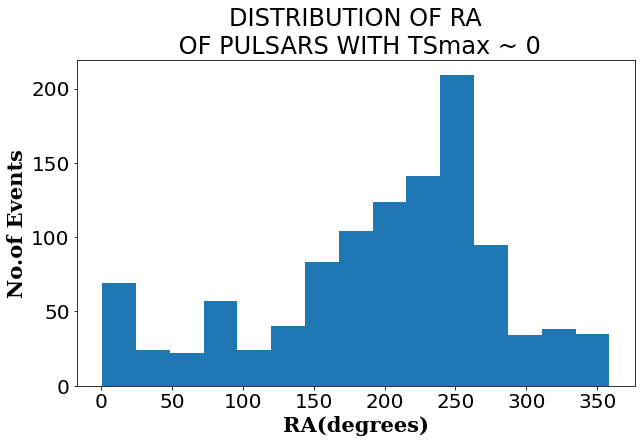

In [24]:
plt.figure(figsize=(10,6))
plt.hist(np.rad2deg(psra), 15)
#plt.hist(msra, 15)
plt.xlabel("RA(degrees)", fontdict=font)
plt.ylabel("No.of Events", fontdict=font)
plt.title("DISTRIBUTION OF RA\n OF PULSARS WITH TSmax ~ 0")
plt.savefig("outputs/psr-tsmax0-RA_Dist.pdf")
plt.show()

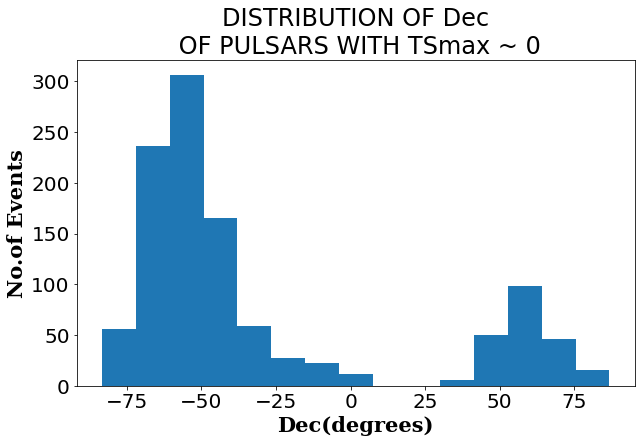

In [25]:
plt.figure(figsize=(10,6))
plt.hist(np.rad2deg(psdec), 15)
#plt.hist(msdec, 15)
plt.xlabel("Dec(degrees)", fontdict=font)
plt.ylabel("No.of Events", fontdict=font)
plt.title("DISTRIBUTION OF Dec\n OF PULSARS WITH TSmax ~ 0")
plt.savefig("outputs/psr-tsmax0-Dec_Dist.pdf")
plt.show()

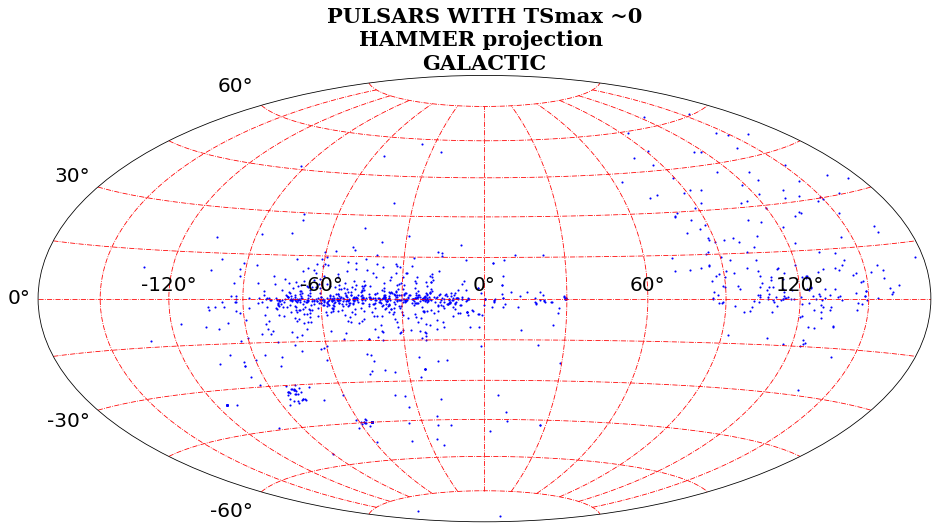

In [26]:
psra = [msra[i] for i in arr]# ra in degree
psdec = [msdec[i] for i in arr] # DEc in degree
radec = scr(ra = psra * u.degree, dec = psdec * u.degree, frame = 'icrs')           #CONVERSION
radec = radec.galactic      #CONVERSION FROM RA,DEC TO GALACTIC COORDINATES

gl = [(i + np.pi)%(2*np.pi) - np.pi for i in radec.l.radian]
gb = radec.b.radian

fig = plt.figure(figsize=(16, 10))
plt.rcParams.update({'font.size': 20})
ax2 = plt.subplot(projection='hammer')
ax2.scatter(gl, gb,marker='o',color='b', s = 1.2)
ax2.xaxis.set_major_locator(plt.FixedLocator(np.pi / 3 * np.linspace(-2,2, 5)))
ax2.xaxis.set_minor_locator(plt.FixedLocator(np.pi / 6 * np.linspace(-5, 5, 11)))
ax2.yaxis.set_major_locator(plt.FixedLocator(np.pi / 6 * np.linspace(-2, 2, 5)))
ax2.yaxis.set_minor_locator(plt.FixedLocator(np.pi / 12 * np.linspace(-5, 5, 11)))
ax2.grid(True, which='both', color='r', lw=0.8, ls='-.')
#ax2.axvspan(min(p3), max(p3), color='pink', alpha=0.5)
ax2.set_title('PULSARS WITH TSmax ~0\nHAMMER projection \nGALACTIC', fontdict=font)
plt.savefig('outputs/psr-tsmax0-HP-Galactic.pdf')
#plt.suptitle(filenamewithpath.replace('icecube_10year_ps/events/','').replace('_exp','') + ' GALACTIC')
plt.show()

In [28]:
radeci = scr(ra = icra * u.degree, dec = icdec * u.degree, frame = 'icrs')           #CONVERSION
radeci = radeci.galactic      #CONVERSION FROM RA,DEC TO GALACTIC COORDINATES

gli = [(i + np.pi)%(2*np.pi) - np.pi for i in radeci.l.radian]
#gli = radeci.l.radian

gbi = radeci.b.radian

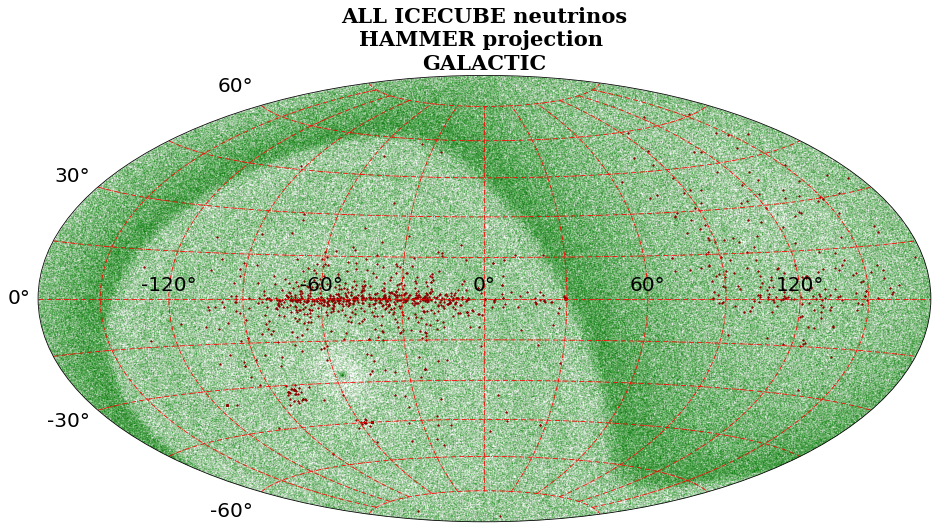

In [33]:
fig = plt.figure(figsize=(16, 10))
plt.rcParams.update({'font.size': 20})
ax2 = plt.subplot(projection='hammer')
ax2.scatter(gli, gbi,marker='o',color='green', s = 0.1, alpha=0.15)
ax2.scatter(gl, gb, marker='*',color='darkred', s = 2)
ax2.xaxis.set_major_locator(plt.FixedLocator(np.pi / 3 * np.linspace(-2,2, 5)))
ax2.xaxis.set_minor_locator(plt.FixedLocator(np.pi / 6 * np.linspace(-5, 5, 11)))
ax2.yaxis.set_major_locator(plt.FixedLocator(np.pi / 6 * np.linspace(-2, 2, 5)))
ax2.yaxis.set_minor_locator(plt.FixedLocator(np.pi / 12 * np.linspace(-5, 5, 11)))
ax2.grid(True, which='both', color='r', lw=0.8, ls='-.')
#ax2.axvspan(min(p3), max(p3), color='pink', alpha=0.5)
ax2.set_title('ALL ICECUBE neutrinos\nHAMMER projection \nGALACTIC', fontdict=font)
plt.savefig('outputs/all-ICnu-HP-Galactic.pdf')
#plt.suptitle(filenamewithpath.replace('icecube_10year_ps/events/','').replace('_exp','') + ' GALACTIC')
plt.show()

In [ ]:
[max(np.abs(gl)), max(np.abs(gb))]

In [ ]:
msdec[4]

In [ ]:
(msra[4], msdec[4])

### SCRAP!!! TO BE DELETED IN THE FINAL VERSION

In [24]:
tempnudec = []
ang = angfinder(4, 20)
cone = 3
for i in range(len(ang)):
    if ang[i] != -1:
        tempnudec.append(np.sin(icdec[i]))#APPENDING SIN(Decl) OF ALL NEUTRINOS WITHIN THE SPECIFIED CUT
    
binwidth = np.sin(np.deg2rad(msdec[psrno] + cone)) - np.sin(np.deg2rad(msdec[psrno] - cone))
sin_dpsr = np.sin(np.deg2rad(msdec[psrno]))
bins = np.arange(-1, 1, binwidth)
ht, walls = np.histogram(tempnudec, bins, density=True)
bctr = (bins[1:]+bins[:-1])/2
i=np.argmin(np.abs(bctr-sin_dpsr))
print(ht[i])

0.3699724574741707


In [47]:
psrno = 258
cut = 20
cone = 3

min = 100
mini = 0
nearcrd=[]
aang = angfinder(psrno, cut)
for i in range(len(aang)):
    if aang[i] != -1:
        nearcrd.append([icra[i], icdec[i], icang[i]])
        if min > aang[i]:
            min = aang[i]
            mini = i
np.savetxt(f"outputs/nnear{psrno}.txt", nearcrd)

In [48]:
cc = [i for i in aang if i != -1]

In [49]:
np.min(cc)

0.23209922204905437

In [50]:
np.savetxt(f"outputs/nunear{psrno}.txt", nearcrd)

In [51]:
hvovec(msra[psrno], msdec[psrno], icra[mini], icdec[mini])

0.23209922204905437

In [52]:
[msra[psrno], msdec[psrno], icra[mini], icdec[mini]]

[272.73133, -18.3442, 272.568, -18.517]

In [35]:
data=np.genfromtxt("outputs/nunear4.txt")
pi = np.pi

nura=data[:,0] #neutrino RA
nudec=data[:,1] #neutrino DEC
angerr=data[:,2] # error in neutrino position

ra=282.5 #pulsar RA
dec= -0.03 # pulsar DEC

cang=np.sin(dec*pi/180.0)*np.sin(nudec*pi/180.0)+ np.cos(dec*pi/180.0)*np.cos(nudec*pi/180.0)*np.cos((ra-nura)*pi/180.0)
pi = np.pi
pdec = msdec[psrno]
radconv=pi/180.0
decwidth=np.sin(radconv*(pdec+3))-np.sin(radconv*((pdec-3)))
sindec=np.sin(nudec)
decbins=np.arange(-1,1,decwidth)
h,e=np.histogram(sindec,bins=decbins,density=True)
c=0.5*(e[1:]+e[:-1]) # get bin centers
i=np.argmin(np.abs(c-np.sin(pdec*radconv)))

In [36]:
h[i]

0.3699724574741707

In [37]:
t1 = [i for i in aang if i != -1]

In [39]:
t1[np.argmin(t1)]

0.23209922204905437

In [ ]:
icra2 = [(i + 180)%360 - 180 for i in icra]


In [ ]:
np.min(icra)

#### >amplitude fixed to total no of events/no of bins between 0 and 1 and then do a fit to this

In [ ]:
data=np.genfromtxt("outputs/nunear4.txt")
pi = np.pi

nura=data[:,0] #neutrino RA
nudec=data[:,1] #neutrino DEC
angerr=data[:,2] # error in neutrino position

ra=282.5 #pulsar RA
dec= -0.03 # pulsar DEC

cang=np.sin(dec*pi/180.0)*np.sin(nudec*pi/180.0)+ np.cos(dec*pi/180.0)*np.cos(nudec*pi/180.0)*np.cos((ra-nura)*pi/180.0)

ang=(180.0/pi)*np.arccos(cang) # angle between pulsar and neutrino in degrees

angerrrad=angerr*pi/180.0 # angle between pulsar and neutrino in radins

N=len(nura) # total no of neutrinos  used for analysis
bkgct=np.count_nonzero(np.abs(nudec-dec)<3) # total no of bkgd neutrinos within 3 degrees


Bi=bkgct/(2.0*pi*N*(np.sin((pi/180)*(dec+3.0))- np.sin((pi/180)*(dec-3.0))))
Si=np.exp(-0.5*(ang/angerr)**2)/(2.0*pi*angerrrad*angerrrad)
# the function rtruns TS(ns) in Zhou paper


def L(x):
    TS=np.log(x*Si/N+(1.0-1.0*x/N)*Bi)-np.log(Bi)
    return 2.0*np.sum(TS)



# since scipy.optimize can only do minization calculate negative of L(x) to maximize L(x)
nll = lambda x: -L(x)
soln = minimize(nll, 5.0,bounds=((0,None),)) # to ensure that ns is > 0
ns=soln.x
print(L(ns))
print(ns)
x=np.linspace(0,600,10)
y=[L(p) for p in x]
plt.plot(x,y,'-')
plt.show()

In [ ]:
b4

In [ ]:
Bi

for each source with$n_s$and TS greater
than 0, we conduct a Monte Carlo simulation. We randomly generate neutrino events isotropically distributed
around the interested source within a distance of 20◦

We then assign energies to each simulated event using the
kernel density estimation of the observed neutrino energy
distribution of each year. The localization error of each
event is subsequently determined from its simulated energy from the relationship of observed event energy and
angular resolution given in the IceCube data. The same
event selection and unbinned likelihood analysis is carried out, and we can get a distribution of$n_s$and TS
from this Monte Carlo simulation. We can then infer
the significance of observed result by comparing it with
the distribution and obtain a p value by calculating the
percentile observed values lie in.

We use the unbinned method to calculate the TS and
corresponding confidence level from Monte Carlo simulations for the association of neutrino events and blazars.
The distribution of the calculated TS is presented in Fig.

3. A total of 30 blazars display$n_s$and TS greater than 0.
The distribution of TS does not deviate too much from
normal distribution, as one would expect from a random
and isotropic distribution of neutrino events.